### Setup

In [1]:
!pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 5.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import plotly.express as px

import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Data and Preprocessing

### Raw data

In [80]:

base_path = ""

In [81]:
df_train = pd.read_csv(base_path + "task_1_information_extraction_train_20k.csv")
df_valid = pd.read_csv(base_path + "task_1_information_extraction_valid_5k.csv")
df_train.head()

,NOTES,EVENT_DATE,SOURCE,FATALITIES,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION
0,Three people were killed while 27 others injur...,29-August-2012,Statesman (Pakistan),3,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Pakistan),3,Civilians (Pakistan),7,37,Jacobabad
1,Government security forces opened fire at a pr...,03-May-2014,Undisclosed Source,0,Violence against civilians,Attack,Military Forces of Somalia (2012-2017),1,Civilians (Somalia),7,17,Baidoa
2,Al Shabaab forces attacked government forces b...,01-May-2012,All Africa,11,Battles,Armed clash,Al Shabaab,2,Military Forces of Somalia (2004-2012),1,12,Hudur
3,Agreement: Rebels resumed peace talks with the...,05-October-2013,AFP,0,Strategic developments,Agreement,MNLA: National Movement for the Liberation of ...,2,Government of Mali (2013-2020),1,12,Bamako
4,The person who had acted as the go-between for...,21-December-2001,Dispatch Kabylie,0,Riots,Violent demonstration,Rioters (Algeria),5,NaN,0,50,Bejaia


In [82]:
df_train.info()
list(df_train.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   NOTES           19420 non-null  object
 1   EVENT_DATE      20000 non-null  object
 2   SOURCE          20000 non-null  object
 3   FATALITIES      20000 non-null  int64 
 4   EVENT_TYPE      20000 non-null  object
 5   SUB_EVENT_TYPE  20000 non-null  object
 6   ACTOR1          20000 non-null  object
 7   INTER1          20000 non-null  int64 
 8   ACTOR2          14904 non-null  object
 9   INTER2          20000 non-null  int64 
 10  INTERACTION     20000 non-null  int64 
 11  LOCATION        20000 non-null  object
dtypes: int64(4), object(8)
memory usage: 1.8+ MB


['NOTES',
 'EVENT_DATE',
 'SOURCE',
 'FATALITIES',
 'EVENT_TYPE',
 'SUB_EVENT_TYPE',
 'ACTOR1',
 'INTER1',
 'ACTOR2',
 'INTER2',
 'INTERACTION',
 'LOCATION']

### Processing

#### drop empty notes rows

In [83]:
is_not_zero = lambda x: x!=0 # Function to return True if value is not zero
df_train.isna().sum().where(is_not_zero).dropna()

NOTES      580.0
ACTOR2    5096.0
dtype: float64

In [84]:
df_train = df_train[df_train['NOTES'].notna()]
df_valid = df_valid[df_valid['NOTES'].notna()]

In [85]:
len(df_train), len(df_valid)

(19420, 4869)

#### Prep feature and target variables

In [86]:
# Features
notes_train, notes_valid = df_train['NOTES'], df_valid['NOTES']
notes_train[3]

'Agreement: Rebels resumed peace talks with the Malian government for the first time since September 26th.'

In [116]:
import itertools

get_map = lambda col_name, df: {s: idx for idx, s in enumerate(df[col_name].factorize()[1])}
get_numeric_vals = lambda col_name, df: df[col_name].replace(get_map(col_name, df))

def get_dual_map(col_name1, col_name2, df): 
    cols_permutation = itertools.product(df[col_name1].factorize()[1], df[col_name2].factorize()[1])
    dual_map = {(str(s[0]) + '-' + str(s[1])): idx for idx, s in enumerate(cols_permutation)}
    return dual_map

def get_dual_numeric_vals(col_name1, col_name2, df):
    temp_combined_col = df[col_name1].astype(str) + '-' + df[col_name2].astype(str) 
    dual_map = get_dual_map(col_name1, col_name2, df)
    numerical_category_col = temp_combined_col.replace(dual_map)
    return numerical_category_col

def get_categorical_train_valid(current_target_col, num_classes):
    target_train = tf.keras.utils.to_categorical(df_train[current_target_col].values, num_classes=num_classes)
    target_valid = tf.keras.utils.to_categorical(df_valid[current_target_col].values, num_classes=num_classes)
    return target_train, target_valid

df_train['EVENT_TYPE'] = get_numeric_vals('EVENT_TYPE', df_train)
df_valid['EVENT_TYPE'] = get_numeric_vals('EVENT_TYPE', df_valid)

df_train['SUB_EVENT_TYPE'] = get_numeric_vals('SUB_EVENT_TYPE', df_train)
df_valid['SUB_EVENT_TYPE'] = get_numeric_vals('SUB_EVENT_TYPE', df_valid)

print(df_train['EVENT_TYPE'].unique(), df_valid['SUB_EVENT_TYPE'].unique())
print(df_train['EVENT_TYPE'].unique(), df_valid['EVENT_TYPE'].unique())

event_map = {}
ctr = 0
for e in list(df_train['EVENT_TYPE'].unique()) + list(df_valid['EVENT_TYPE'].unique()):
    for sub_e in list(df_train['SUB_EVENT_TYPE'].unique()) + list(df_valid['SUB_EVENT_TYPE'].unique()):
        event_map[str(e) + '-' + str(sub_e)] = ctr
        ctr += 1
event_map

[0 1 2 3 4 5] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[0 1 2 3 4 5] [0 1 2 3 4 5]


{'0-0': 312,
 '0-1': 313,
 '0-10': 322,
 '0-11': 323,
 '0-12': 324,
 '0-13': 325,
 '0-14': 326,
 '0-15': 327,
 '0-16': 328,
 '0-17': 329,
 '0-18': 330,
 '0-19': 331,
 '0-2': 314,
 '0-20': 332,
 '0-21': 333,
 '0-22': 334,
 '0-23': 335,
 '0-3': 315,
 '0-4': 316,
 '0-5': 317,
 '0-6': 318,
 '0-7': 319,
 '0-8': 320,
 '0-9': 321,
 '1-0': 360,
 '1-1': 361,
 '1-10': 370,
 '1-11': 371,
 '1-12': 372,
 '1-13': 373,
 '1-14': 374,
 '1-15': 375,
 '1-16': 376,
 '1-17': 377,
 '1-18': 378,
 '1-19': 379,
 '1-2': 362,
 '1-20': 380,
 '1-21': 381,
 '1-22': 382,
 '1-23': 383,
 '1-3': 363,
 '1-4': 364,
 '1-5': 365,
 '1-6': 366,
 '1-7': 367,
 '1-8': 368,
 '1-9': 369,
 '2-0': 408,
 '2-1': 409,
 '2-10': 418,
 '2-11': 419,
 '2-12': 420,
 '2-13': 421,
 '2-14': 422,
 '2-15': 423,
 '2-16': 424,
 '2-17': 425,
 '2-18': 426,
 '2-19': 427,
 '2-2': 410,
 '2-20': 428,
 '2-21': 429,
 '2-22': 430,
 '2-23': 431,
 '2-3': 411,
 '2-4': 412,
 '2-5': 413,
 '2-6': 414,
 '2-7': 415,
 '2-8': 416,
 '2-9': 417,
 '3-0': 456,
 '3-1': 4

In [118]:
# just add moar columns
# df_train['EVENT_TYPE_SUB_EVENT_TYPE'] = get_dual_numeric_vals('EVENT_TYPE', 'SUB_EVENT_TYPE', df_train)
# df_train['INTER1_INTER2'] = get_dual_numeric_vals('INTER1', 'INTER2', df_train)

# df_valid['EVENT_TYPE_SUB_EVENT_TYPE'] = get_dual_numeric_vals('EVENT_TYPE', 'SUB_EVENT_TYPE', df_valid)
# df_valid['INTER1_INTER2'] = get_dual_numeric_vals('INTER1', 'INTER2', df_valid)

df_train['EVENT_TYPE_SUB_EVENT_TYPE'] = (df_train['EVENT_TYPE'].apply(str) + '-' + df_train['SUB_EVENT_TYPE'].apply(str)).replace(event_map)

df_train['EVENT_TYPE_SUB_EVENT_TYPE']

df_valid['EVENT_TYPE_SUB_EVENT_TYPE'] = (df_valid['EVENT_TYPE'].apply(str) + '-' + df_valid['SUB_EVENT_TYPE'].apply(str)).replace(event_map)

df_valid['EVENT_TYPE_SUB_EVENT_TYPE']

0       312
1       361
2       410
3       410
4       312
       ... 
4995    312
4996    410
4997    312
4998    312
4999    335
Name: EVENT_TYPE_SUB_EVENT_TYPE, Length: 4869, dtype: int64

In [119]:
col = 'EVENT_TYPE_SUB_EVENT_TYPE'

In [129]:
new_event_map = {}
ctr = 0
for tc in df_train[col].unique():
    if tc not in new_event_map:
        new_event_map[tc] = ctr
        ctr += 1
for vc in df_valid[col].unique():
    if vc not in new_event_map:
        new_event_map[vc] = ctr
        ctr += 1

In [130]:
df_train['EVENT_TYPE_SUB_EVENT_TYPE'] = df_train['EVENT_TYPE_SUB_EVENT_TYPE'].replace(new_event_map)

df_train['EVENT_TYPE_SUB_EVENT_TYPE']

df_valid['EVENT_TYPE_SUB_EVENT_TYPE'] = df_valid['EVENT_TYPE_SUB_EVENT_TYPE'].replace(new_event_map)

df_valid['EVENT_TYPE_SUB_EVENT_TYPE']

0        0
1        1
2        2
3        2
4        0
        ..
4995     0
4996     2
4997     0
4998     0
4999    40
Name: EVENT_TYPE_SUB_EVENT_TYPE, Length: 4869, dtype: int64

In [133]:
print(df_train[col].unique(), df_valid[col].unique())

num_classes = df_train[col].unique().shape[0]
num_classes_valid = df_valid[col].unique().shape[0]
len(new_event_map)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [ 0  1  2  3 24 25 26 27 28  9 29 11 30 31 32 15 33 34 35 36 37 38 39 40]


41

In [141]:
inter_map = {}
ctr = 0
for e in list(df_train['INTER1'].unique()) + list(df_valid['INTER1'].unique()):
    for sub_e in list(df_train['INTER2'].unique()) + list(df_valid['INTER2'].unique()):
        inter_map[str(e) + '-' + str(sub_e)] = ctr
        ctr += 1
print(inter_map)

col_inter = 'INTER1_INTER2'

df_train[col_inter] = (df_train['INTER1'].apply(str) + '-' + df_train['INTER2'].apply(str)).replace(inter_map)
df_valid[col_inter] = (df_valid['INTER1'].apply(str) + '-' + df_valid['INTER2'].apply(str)).replace(inter_map)

print(df_train[col_inter], df_valid[col_inter])

new_inter_map = {}
ctr = 0
for tc in df_train[col_inter].unique():
    if tc not in new_inter_map:
        new_inter_map[tc] = ctr
        ctr += 1
for vc in df_valid[col_inter].unique():
    if vc not in new_inter_map:
        new_inter_map[vc] = ctr
        ctr += 1

df_train[col_inter] = df_train[col_inter].replace(new_inter_map)
df_valid[col_inter] = df_valid[col_inter].replace(new_inter_map)

print(df_valid[col_inter], df_train[col_inter])

print(df_train[col_inter].unique(), df_valid[col_inter].unique())

num_classes = df_train[col_inter].unique().shape[0]
num_classes_valid = df_valid[col_inter].unique().shape[0]
len(new_inter_map)

{'3-7': 171, '3-1': 174, '3-0': 177, '3-2': 172, '3-4': 178, '3-3': 173, '3-8': 176, '3-5': 179, '3-6': 175, '1-7': 153, '1-1': 156, '1-0': 159, '1-2': 154, '1-4': 160, '1-3': 155, '1-8': 158, '1-5': 161, '1-6': 157, '2-7': 135, '2-1': 138, '2-0': 141, '2-2': 136, '2-4': 142, '2-3': 137, '2-8': 140, '2-5': 143, '2-6': 139, '5-7': 243, '5-1': 246, '5-0': 249, '5-2': 244, '5-4': 250, '5-3': 245, '5-8': 248, '5-5': 251, '5-6': 247, '6-7': 225, '6-1': 228, '6-0': 231, '6-2': 226, '6-4': 232, '6-3': 227, '6-8': 230, '6-5': 233, '6-6': 229, '8-7': 189, '8-1': 192, '8-0': 195, '8-2': 190, '8-4': 196, '8-3': 191, '8-8': 194, '8-5': 197, '8-6': 193, '4-7': 207, '4-1': 210, '4-0': 213, '4-2': 208, '4-4': 214, '4-3': 209, '4-8': 212, '4-5': 215, '4-6': 211, '7-7': 261, '7-1': 264, '7-0': 267, '7-2': 262, '7-4': 268, '7-3': 263, '7-8': 266, '7-5': 269, '7-6': 265}
0        171
1        153
2        138
3        138
4        249
        ... 
19995    231
19996    137
19997    138
19998    231
19999

61

In [121]:
print(notes_train.shape, df_train['EVENT_TYPE_SUB_EVENT_TYPE'].shape, df_train[col_inter].shape)
print(notes_valid.shape, df_valid['EVENT_TYPE_SUB_EVENT_TYPE'].shape, df_valid[col_inter].shape)
# print(newsgroups_test.target.shape, newsgroups_test.target.shape)

(19420,) (19420,)
(4869,) (4869,)


## BERT

In [20]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 4.7 MB/s 
     |████████████████████████████████| 462 kB 44.5 MB/s 


In [21]:
import tensorflow_hub as hub
import tensorflow_text as text


tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

# preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
# encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

preprocessor = hub.KerasLayer(tfhub_handle_preprocess)  # bert_preprocess_model
encoder = hub.KerasLayer(tfhub_handle_encoder)  # bert_model

### Try encoding text

In [22]:
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

print(notes_train[3])
get_embeddings([notes_train[3]])

Agreement: Rebels resumed peace talks with the Malian government for the first time since September 26th.


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 9.80098307e-01,  5.18458188e-01,  7.56239891e-02,
         3.01929981e-01, -4.63083647e-02,  7.48234212e-01,
         9.89596069e-01, -9.87496555e-01, -5.58307357e-02,
        -9.89190876e-01,  1.40807629e-01, -8.15477252e-01,
         1.97780102e-01, -9.90958035e-01, -8.30306768e-01,
         1.71104982e-01, -1.21636242e-02, -3.48521583e-02,
        -6.02742851e-01,  2.88039241e-02,  7.05780974e-03,
        -3.61454070e-01,  9.63866562e-02,  7.29771852e-01,
         9.97709930e-01,  7.76730120e-01, -4.15004224e-01,
        -3.63979548e-01,  7.68609568e-02,  3.70770872e-01,
         9.25985634e-01, -7.52986595e-02, -1.00480262e-02,
        -9.37810168e-04, -9.52462375e-01, -1.40243664e-01,
         1.10086419e-01,  5.11598103e-02,  9.72281575e-01,
        -3.84795547e-01, -3.87432694e-01, -1.12843484e-01,
         2.12826222e-01, -9.96648490e-01,  5.01680523e-02,
         9.86772537e-01, -2.41996065e-01,  3.90086710e-01,
      

In [23]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


def plot_similarity(features, labels):
    """Plot a similarity matrix of the embeddings."""
    cos_sim = cosine_similarity(features)
    fig = plt.figure(figsize=(10,8))
    sns.set(font_scale=1.2)
    cbar_kws=dict(use_gridspec=False, location="left")
    g = sns.heatmap(
        cos_sim, xticklabels=labels, yticklabels=labels,
        vmin=0, vmax=1, annot=True, cmap="Blues", 
        cbar_kws=cbar_kws)
    g.tick_params(labelright=True, labelleft=False)
    g.set_yticklabels(labels, rotation=0)
    g.set_title("Semantic Textual Similarity")

In [25]:
df_train[['NOTES', 'EVENT_TYPE']].tail(5)

,NOTES,EVENT_TYPE
19995,"On Thursday, BJP state president and his suppo...",5
19996,At around 03.00 in the night of 07-08/03/11 AS...,2
19997,The SPLM-N launched attacks on government posi...,2
19998,The residents of Khairpur protested outside th...,5
19999,Members of the ICU protest a proposed liquor b...,5


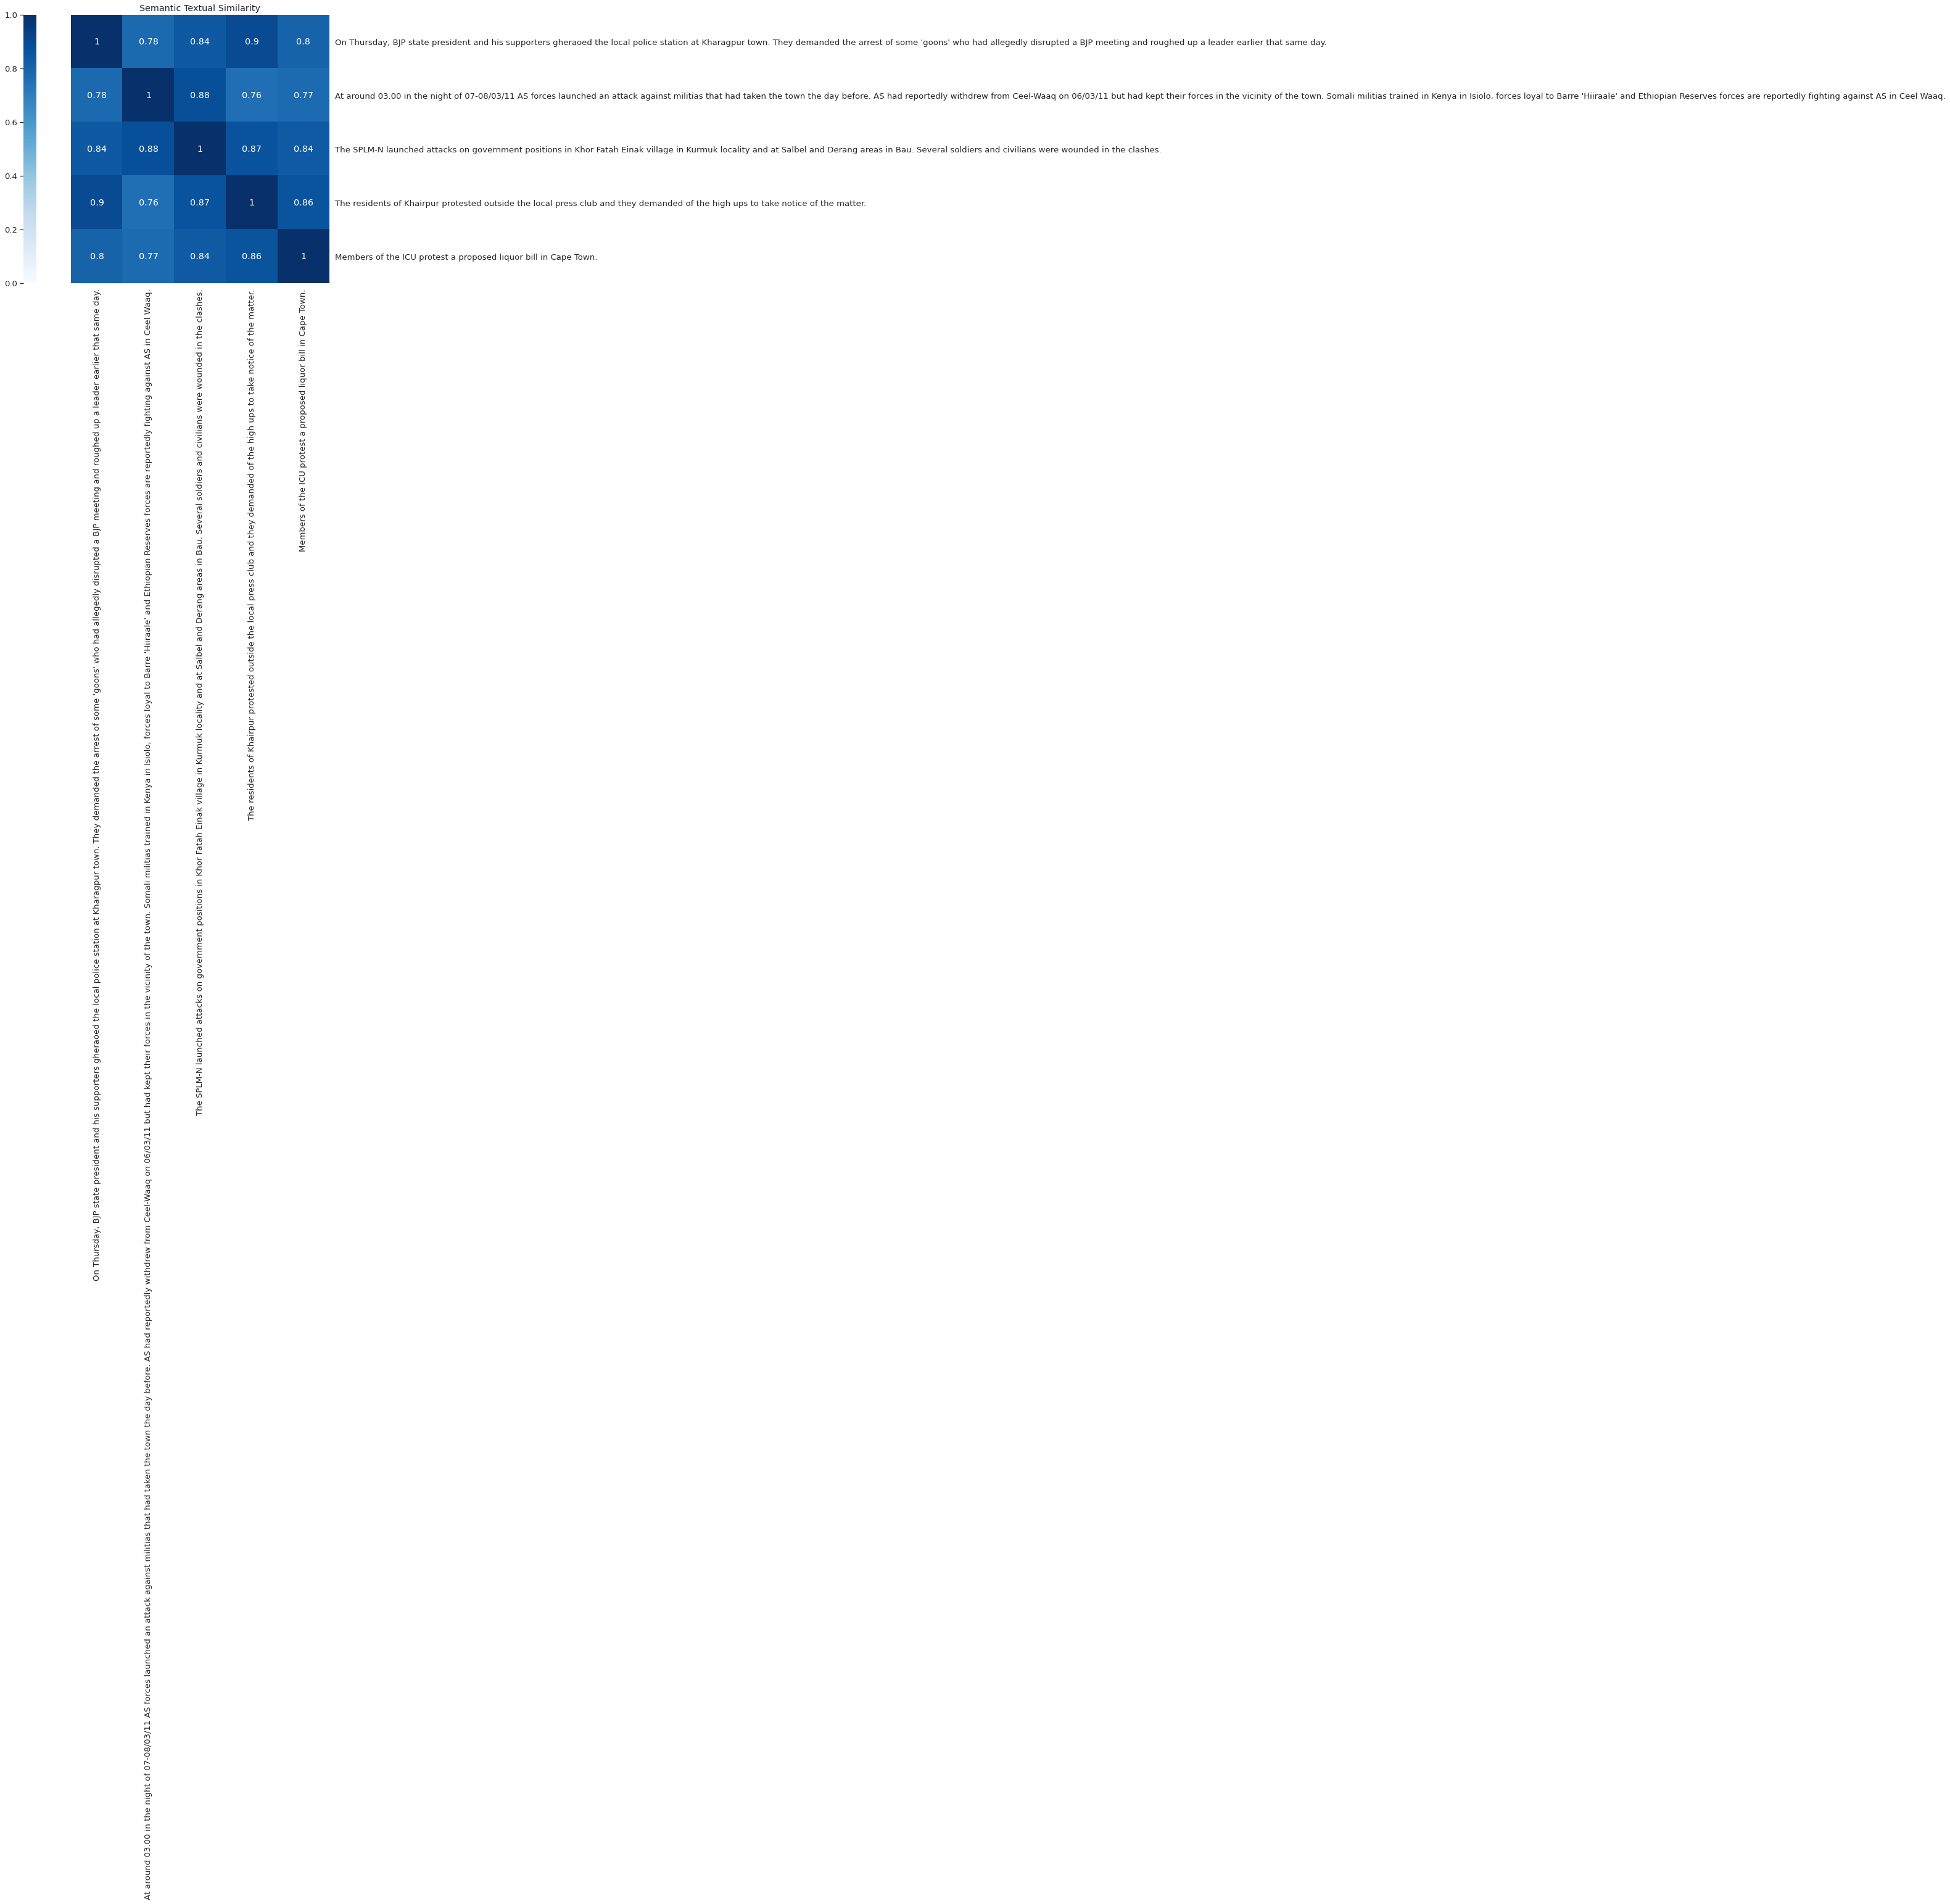

In [26]:
plot_similarity(get_embeddings(notes_train[-5:]), notes_train[-5:])

## Classifier Model

### Metrics

In [122]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

### Column

In [123]:
col = 'EVENT_TYPE_SUB_EVENT_TYPE'

In [135]:
num_classes = len(new_event_map)

num_classes

41

In [125]:
target_train = tf.keras.utils.to_categorical([1,2], num_classes=num_classes+2)
target_train

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [136]:
target_train = tf.keras.utils.to_categorical(df_train[col].values, num_classes=num_classes)
target_valid = tf.keras.utils.to_categorical(df_valid[col].values, num_classes=num_classes)

### Model

In [137]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

### Training

In [138]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 217s 336ms/step - loss: 1.4914 - accuracy: 0.5490 - balanced_recall: 0.0391 - balanced_precision: 0.0555 - balanced_f1_score: 0.0452 - val_loss: 4.6016 - val_accuracy: 0.3038 - val_balanced_recall: 0.0148 - val_balanced_precision: 0.0165 - val_balanced_f1_score: 0.0149
Epoch 2/5
607/607 [==============================] - 192s 316ms/step - loss: 1.1501 - accuracy: 0.6255 - balanced_recall: 0.0593 - balanced_precision: 0.0746 - balanced_f1_score: 0.0656 - val_loss: 4.7399 - val_accuracy: 0.3052 - val_balanced_recall: 0.0155 - val_balanced_precision: 0.0172 - val_balanced_f1_score: 0.0157
Epoch 3/5
607/607 [==============================] - 151s 249ms/step - loss: 1.0651 - accuracy: 0.6465 - balanced_recall: 0.0687 - balanced_precision: 0.0848 - balanced_f1_score: 0.0755 - val_loss: 5.1271 - val_accuracy: 0.3177 - val_balanced_recall: 0.0171 - val_balanced_precision: 0.0157 - val_balanced_f1_score: 0.0158
Epoch 4/5
607/607 [============

### Performance: EVENT_TYPE_SUB_EVENT_TYPE

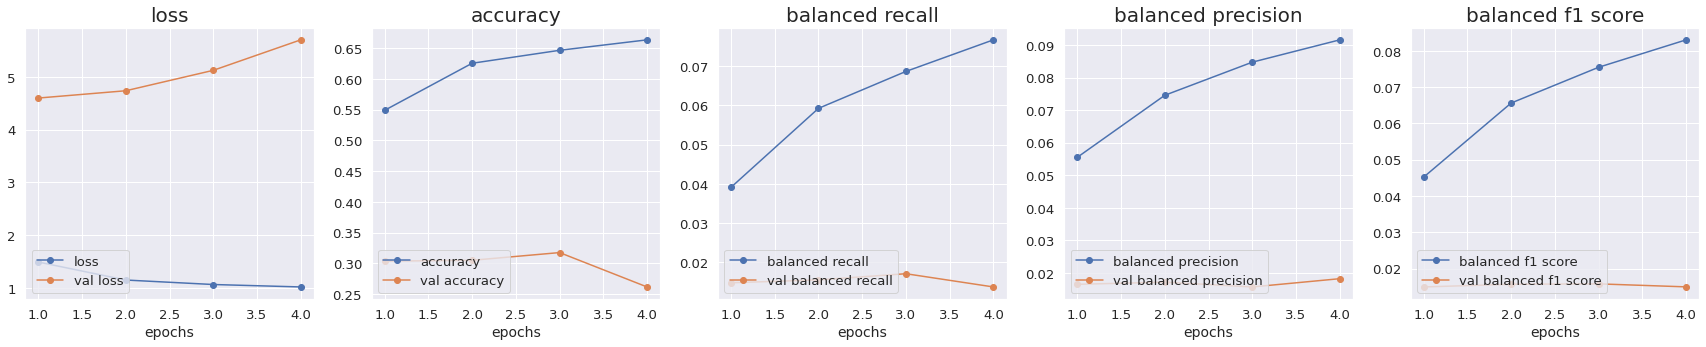

In [140]:
x = list(range(1, n_epochs))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [143]:
col = 'INTER1_INTER2'

In [144]:
num_classes = len(new_inter_map)

num_classes

61

In [145]:
target_train = tf.keras.utils.to_categorical(df_train[col].values, num_classes=num_classes)
target_valid = tf.keras.utils.to_categorical(df_valid[col].values, num_classes=num_classes)

In [146]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [147]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 177s 267ms/step - loss: 2.2811 - accuracy: 0.3963 - balanced_recall: 0.0161 - balanced_precision: 0.0228 - balanced_f1_score: 0.0184 - val_loss: 2.3458 - val_accuracy: 0.3270 - val_balanced_recall: 0.0095 - val_balanced_precision: 0.0157 - val_balanced_f1_score: 0.0111
Epoch 2/5
607/607 [==============================] - 154s 254ms/step - loss: 1.9032 - accuracy: 0.4604 - balanced_recall: 0.0252 - balanced_precision: 0.0342 - balanced_f1_score: 0.0286 - val_loss: 2.2271 - val_accuracy: 0.3471 - val_balanced_recall: 0.0121 - val_balanced_precision: 0.0196 - val_balanced_f1_score: 0.0140
Epoch 3/5
607/607 [==============================] - 155s 256ms/step - loss: 1.8021 - accuracy: 0.4801 - balanced_recall: 0.0311 - balanced_precision: 0.0421 - balanced_f1_score: 0.0353 - val_loss: 2.1160 - val_accuracy: 0.3855 - val_balanced_recall: 0.0141 - val_balanced_precision: 0.0253 - val_balanced_f1_score: 0.0171
Epoch 4/5
607/607 [============

### Performance INTER1_INTER2

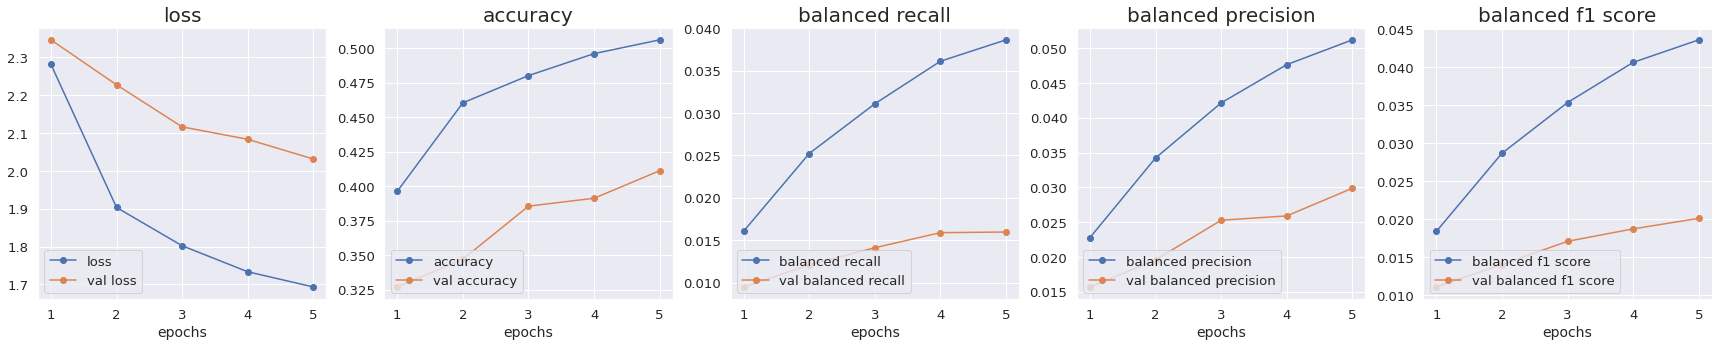

In [149]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

### Predict

In [ ]:
import numpy as np

def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


# predict_class(reviews)

In [ ]:
# from sklearn.metrics import classification_report


# y_pred = predict_class(test_set["Text"])
# print(classification_report(test_set["Labels"], y_pred))

### Save

In [ ]:
model.save("multiclass_v1")

INFO:tensorflow:Assets written to: multiclass_v1/assets


INFO:tensorflow:Assets written to: multiclass_v1/assets


In [ ]:
!zip -r 'multiclass_v1.zip' 'multiclass_v1'

  adding: multiclass_v1/ (stored 0%)
  adding: multiclass_v1/assets/ (stored 0%)
  adding: multiclass_v1/assets/vocab.txt (deflated 53%)
  adding: multiclass_v1/saved_model.pb (deflated 92%)
  adding: multiclass_v1/variables/ (stored 0%)
  adding: multiclass_v1/variables/variables.index (deflated 75%)
  adding: multiclass_v1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: multiclass_v1/keras_metadata.pb (deflated 84%)


In [ ]:
import pickle

with open('multiclass_v1_history', 'wb') as file_pi:
    pickle.dump(model_fit.history, file_pi)

In [ ]:
from tensorflow import keras

# load model
new_model = keras.models.load_model("multiclass_v1", custom_objects = {"balanced_recall": balanced_recall, "balanced_precision": balanced_precision, "balanced_f1_score": balanced_f1_score})
# so, I think in order to deserialize the model more conveniently, these two metrics should subclass tf.keras.metrics.Metric

# test predictions
[np.argmax(pred) for pred in new_model.predict(notes_valid[-5:])]
# output: [3, 1, 0]

[1, 1, 1, 1, 1]

## sub event 

In [ ]:
# Target
event_type_int_map = {s: idx for idx, s in enumerate(df_train['SUB_EVENT_TYPE'].factorize()[1])}
print(event_type_int_map)
num_classes = len(event_type_int_map)
df_train['SUB_EVENT_TYPE'] = df_train['SUB_EVENT_TYPE'].replace(event_type_int_map)
df_valid['SUB_EVENT_TYPE'] = df_valid['SUB_EVENT_TYPE'].replace(event_type_int_map)

# y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)
target_train = tf.keras.utils.to_categorical(df_train['SUB_EVENT_TYPE'].values, num_classes=num_classes)
target_valid = tf.keras.utils.to_categorical(df_valid['SUB_EVENT_TYPE'].values, num_classes=num_classes)

{'Remote explosive/landmine/IED': 0, 'Attack': 1, 'Armed clash': 2, 'Agreement': 3, 'Violent demonstration': 4, 'Peaceful protest': 5, 'Mob violence': 6, 'Sexual violence': 7, 'Protest with intervention': 8, 'Arrests': 9, 'Grenade': 10, 'Abduction/forced disappearance': 11, 'Disrupted weapons use': 12, 'Government regains territory': 13, 'Air/drone strike': 14, 'Non-state actor overtakes territory': 15, 'Excessive force against protesters': 16, 'Shelling/artillery/missile attack': 17, 'Suicide bomb': 18, 'Headquarters or base established': 19, 'Looting/property destruction': 20, 'Change to group/activity': 21, 'Non-violent transfer of territory': 22, 'Other': 23}


In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 5

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 163s 258ms/step - loss: 1.4956 - accuracy: 0.5841 - balanced_recall: 0.0666 - balanced_precision: 0.0933 - balanced_f1_score: 0.0765 - val_loss: 1.3191 - val_accuracy: 0.5654 - val_balanced_recall: 0.0503 - val_balanced_precision: 0.0724 - val_balanced_f1_score: 0.0583
Epoch 2/5
607/607 [==============================] - 152s 251ms/step - loss: 1.1565 - accuracy: 0.6271 - balanced_recall: 0.1012 - balanced_precision: 0.1275 - balanced_f1_score: 0.1121 - val_loss: 1.1851 - val_accuracy: 0.6067 - val_balanced_recall: 0.0687 - val_balanced_precision: 0.0832 - val_balanced_f1_score: 0.0743
Epoch 3/5
607/607 [==============================] - 160s 264ms/step - loss: 1.0704 - accuracy: 0.6426 - balanced_recall: 0.1183 - balanced_precision: 0.1431 - balanced_f1_score: 0.1288 - val_loss: 1.1219 - val_accuracy: 0.6219 - val_balanced_recall: 0.0789 - val_balanced_precision: 0.0979 - val_balanced_f1_score: 0.0864
Epoch 4/5
607/607 [============

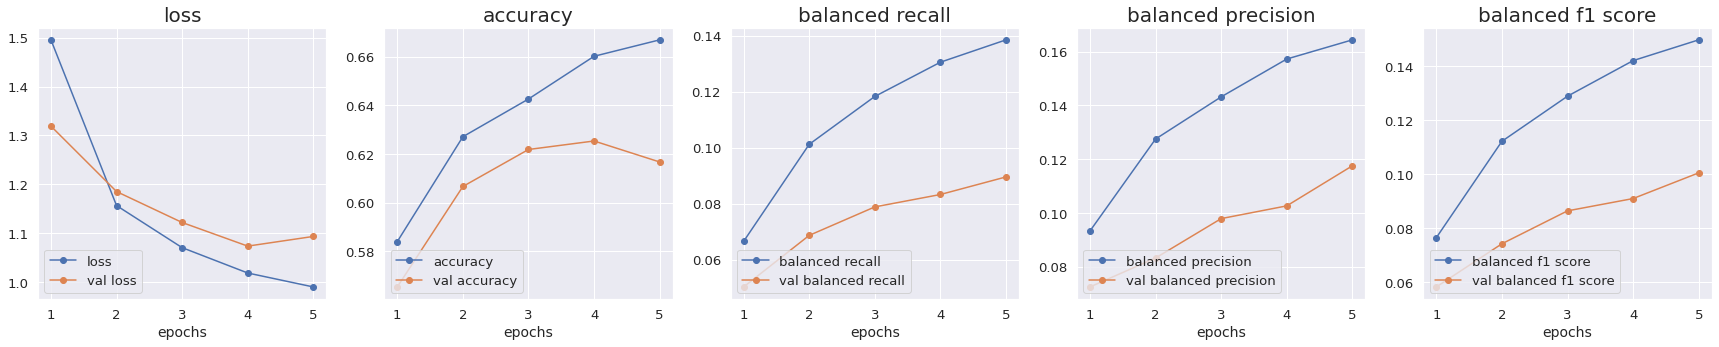

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

## Fatalities

In [ ]:
# Target
target_train = df_train['FATALITIES'].astype('float')
target_valid = df_valid['FATALITIES'].astype('float')

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(len(event_type_int_map), activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(
    optimizer=tf.optimizers.RMSprop(learning_rate=0.001),
    loss='mean_absolute_error', metrics=METRICS)

model_fit = model.fit(notes_train, 
                      target_train, 
                      epochs = n_epochs,
                      validation_data = (notes_valid, target_valid),
                      callbacks = [earlystop_callback])

Epoch 1/5
607/607 [==============================] - 171s 276ms/step - loss: 5.4144 - mean_squared_error: 1802.4746 - val_loss: 5.8913 - val_mean_squared_error: 718.5144
Epoch 2/5
607/607 [==============================] - 153s 253ms/step - loss: 5.4144 - mean_squared_error: 1802.4746 - val_loss: 5.8913 - val_mean_squared_error: 718.5144
Epoch 3/5
607/607 [==============================] - 154s 254ms/step - loss: 5.4144 - mean_squared_error: 1802.4738 - val_loss: 5.8913 - val_mean_squared_error: 718.5144
Epoch 4/5
607/607 [==============================] - 153s 253ms/step - loss: 5.4144 - mean_squared_error: 1802.4747 - val_loss: 5.8913 - val_mean_squared_error: 718.5144


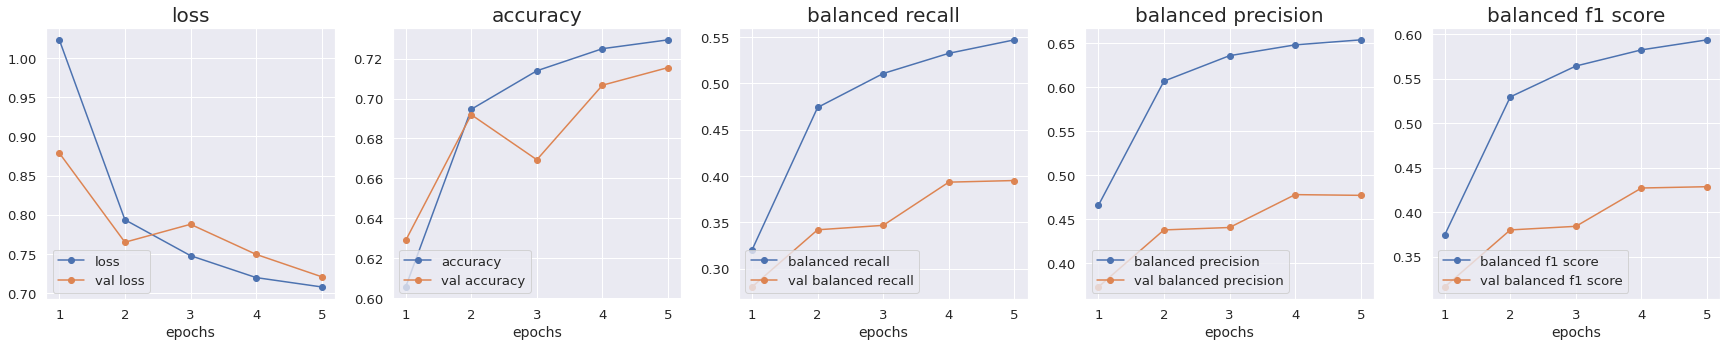

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")